Fichier de test 2d HL-RF


Starting a 2d version of iHL-RF to understand well how it works


In [220]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#start the global attack function as an object

class HLRF_attack:
	def __init__(self, f, deltaf, c=2, x0 = (0,0), maxiter = 100,tau = 0.6, omega = 1e-2,epsilon = 0, show_mer_at_iter = False):
		self.f = lambda x: f(x) + epsilon
		self.deltaf = deltaf
		self.c = c
		self.omega = omega
		self.tau = tau
		self.x0 = x0
		self.maxiter = maxiter
		self.x = x0
		self.xs = [x0]
		self.fs = [f(x0)]
		self.dfs = [deltaf(x0)]
		self.ds = [self.descent_direction()]
		self.sig = 0
		self.sigmas = []
		self.arm = []
		self.delta = abs(f(x0)) * 10**(-3)
		self.epsilon = epsilon
		self.best_x = x0
		self.found_adv = False
		self.nbr_iter = 0
		self.show_mer_at_iter = show_mer_at_iter

	def descent_direction(self):
		if np.linalg.norm(self.deltaf(self.x)) == 0:
			print("The gradient is null")
			return np.zeros_like(self.x)
		else:
			"""
					[(deltaf.x)-f / deltaf**2] deltaf - x
			"""
			d = ((np.dot(self.deltaf(self.x),self.x)-self.f(self.x))/(np.linalg.norm(self.deltaf(self.x),2)**2)) * self.deltaf(self.x) - self.x
			return d / np.linalg.norm(d,2)
			return ((np.dot(self.deltaf(self.x),self.x)-self.f(self.x))/(np.linalg.norm(self.deltaf(self.x),2)**2)) * self.deltaf(self.x) - self.x

	def merit_function(self, x):
		return 0.5 * np.linalg.norm(x)**2 + self.sig * abs(self.f(x))

	def grad_merit_function(self, x):
		return np.linalg.norm(x) + self.c * (1 if self.f(x) > 0 else -1) * self.deltaf(x) 


	def armijo(self):
		mer = self.merit_function(self.x)
		grad_mer = self.grad_merit_function(self.x)
		armijo_cond = self.omega * np.dot(grad_mer,self.ds[-1])
		i=0
		next_mer = self.merit_function(self.x+self.tau**i * self.ds[-1])
		bool_arm_cond = not(next_mer < self.tau**i * armijo_cond + mer)
		while(bool_arm_cond and i<10):
			next_mer = self.merit_function(self.x+self.tau**i * self.ds[-1])
			bool_arm_cond = not(next_mer < self.tau**i * armijo_cond + mer)
			i+=1
			self.nbr_iter += 1
		self.arm.append(self.tau**i)
		return self.tau**(i)


	def step(self):
		dsc_dir = self.descent_direction()
		self.ds.append(dsc_dir)
		tau_armijo = self.armijo()
		self.x = self.x + tau_armijo * dsc_dir
		self.xs.append(self.x)
		self.fs.append(self.f(self.x))
		self.dfs.append(self.deltaf(self.x))
		if self.f(self.x) < 0 and not(self.found_adv):
			self.best_x = self.x
			self.found_adv = True
		elif np.linalg.norm(self.x) < np.linalg.norm(self.best_x) and self.found_adv and self.f(self.x) < 0:
			self.best_x = self.x
		elif self.f(self.x) < self.f(self.best_x) and not(self.found_adv):
			self.best_x = self.x
		self.nbr_iter += 2
		

	def sigma(self):
		if (abs(self.f(self.x)) >= self.delta):
			self.sig = self.c * max(np.linalg.norm(self.x)/np.linalg.norm(self.deltaf(self.x)),0.5 * np.linalg.norm(self.x - self.ds[-1])**2 / abs(self.f(self.x)))
		else:
			self.sig = self.c * np.linalg.norm(self.x)/np.linalg.norm(self.deltaf(self.x))
		self.sigmas.append(self.sig)


	def __call__(self):
		print("Starting the attack")
		i=0
		while self.nbr_iter < self.maxiter:
			self.sigma()
			self.step()
			i+=1
			if self.show_mer_at_iter == i:
				mer = self.merit_function(self.x)
				grad_mer = self.grad_merit_function(self.x)
				armijo_cond = self.omega * np.dot(grad_mer,self.ds[-1])
				# plot the merit function for the direction of descent
				xs = np.linspace(0,1,100)
				ys = np.zeros_like(xs)
				for i in range(len(xs)):
					ys[i] = self.merit_function(self.x + xs[i] * self.ds[-1])
				plt.plot(xs,ys)
				# plot the armijo condition
				Arm = np.zeros_like(xs)
				for i in range(len(xs)):
					Arm[i] = xs[i] * armijo_cond + mer
				print('armijo_cond = ',armijo_cond)
				plt.plot(xs,Arm)
				plt.plot(self.arm[-1],self.arm[-1]*armijo_cond + mer,'ro')
				plt.show()
			

		if not(self.found_adv):
			print("No adversarial example found")

class nHLRF_attack(HLRF_attack):
	def __init__(self, f, deltaf, c=100, x0=(0, 0), maxiter=100 , tau=1, omega=0.01, omega2=0.9,epsilon=0):
		super().__init__(f, deltaf, c, x0, maxiter, tau, omega,epsilon)
		self.omega2 = omega2
		self.sig = 100

	def merit_function(self, x):
		# try to return the value, if it is not possible, return a very big number
		try:
			return 0.5 * np.linalg.norm(x)**2 + 0.5 * self.sig * self.f(x)**2
		except:
			return 10**10

	def grad_merit_function(self, x):
		return np.linalg.norm(x) + self.sig * self.f(x) * self.deltaf(x)

	def armijo(self):
		tau = self.tau
		mer = self.merit_function(self.x)
		grad_mer = self.grad_merit_function(self.x)
		armijo_cond = self.omega * np.dot(grad_mer,self.ds[-1])
		wolfe_cond = self.omega2 * np.dot(grad_mer,self.ds[-1])
		bool_cond = True
		i=0
		while i<5:
			next_mer = self.merit_function(self.x + tau**i * self.ds[-1])
			grad_next_mer = self.grad_merit_function(self.x + tau**i * self.ds[-1])
			self.nbr_iter += 2
			if next_mer > mer + tau * armijo_cond:
				tau = 0.5 * tau
			elif np.dot(grad_next_mer,self.ds[-1]) < wolfe_cond:
				tau = 2 * tau
			else:
				break
			i+=1
		self.arm.append(tau)
		return tau

	def sigma(self):
		if abs(self.f(self.x)) < self.delta:
			self.sig = self.c
		elif np.linalg.norm(self.deltaf(self.x)) == 0:
			print("The gradient is null")
			self.sig = 0
		else:
			self.sig = self.c * abs(np.dot(self.x,self.deltaf(self.x))/ (np.linalg.norm(self.deltaf(self.x))**2 * self.f(self.x)))
		self.sigmas.append(self.sig)




Create a function we want to test


[[0.08858606 0.98123627]
 [0.72042289 0.52669455]
 [0.5803817  0.85491141]
 [0.7215256  0.8104829 ]
 [0.7204625  0.6651503 ]
 [0.21066528 0.86281451]
 [0.83824721 0.7599016 ]
 [0.76536649 0.07963333]
 [0.25477902 0.46358161]
 [0.68801658 0.01192953]] xi
[ 1  1  1 -1 -1  1  1 -1  1 -1] c
13.314639755290854
[ 1.00834696 -0.84363267]


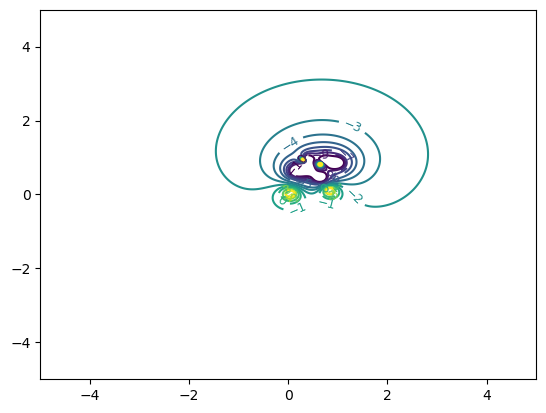

In [221]:
#test with a function f(x) = sum ci/(norm(x-xi)+epsilon) where ci are +-1 and xi are random points in R^2
#and its gradient deltaf(x) = sum ci/(2*(norm(x-xi)**2+epsilon)) 
#where epsilon is a small number to avoid division by zero
#to assure that f(0)>0 ,the closer point xi to 0 have a ci=1

def f(x):
	return 0
x0 = np.array([0,0])
while(f(x0))<=0:
	c = np.random.choice([-1,1],size=10)
	xi = np.random.rand(10,2)
	i = np.argmin(np.linalg.norm(xi,axis=1))
	c[i] = 1
	epsilon = 10**(-2)

	def f(x):
		return np.sum(c/(np.linalg.norm(x-xi,axis=1) + epsilon)) -1

	def deltaf(x):
		a =  c/(2*(np.linalg.norm(x-xi,axis=1)**2 + epsilon))
		d = np.zeros((10,2))
		for i in range(10):
			b = np.zeros(2)
			for j in range(2):
				b[j] = a[i] * (x[j]-xi[i,j])
			d[i] = b
		return -np.sum(d,axis=0)

print(xi,'xi')
print(c,'c')

xi = [[0.18159933, 0.63289692],
 [0.64536029, 0.45105024],
 [0.64812356, 0.81610705],
 [0.37738206, 0.9623183 ],
 [0.84385276, 0.09877855],
 [0.38676203, 0.73889815],
 [0.30974669, 0.93882869],
 [0.9809161,  0.85443344],
 [0.04143833, 0.02102322],
 [0.73445146, 0.89880131]]
c = [-1, -1,  1, -1,  1, -1,  1, -1,  1, -1]


def f(x):
	a=0
	for i in range(10):
		a += c[i]/(np.linalg.norm((x[0]-xi[i][0],x[1]-xi[i][1])) + epsilon)
	return a -1

def deltaf(x):
	a = [0] * 10 
	for i in range(10):
		a [i]= c[i]/(2*(np.linalg.norm((x[0]-xi[i][0],x[1]-xi[i][1]))**2 + epsilon))
	d = np.zeros((10,2))
	for i in range(10):
		b = np.zeros(2)
		for j in range(2):
			b[j] = a[i] * (x[j]-xi[i][j])
		d[i] = b
	return -np.sum(d,axis=0)

print(f(x0))
print(deltaf(x0))

x = np.linspace(-5,5,1000)
y = np.linspace(-5,5,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))
for i in range(1000):
	for j in range(1000):
		Z[i,j] = f((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
plt.show()

Create an other function

[[0.18159933, 0.63289692], [0.64536029, 0.45105024], [0.64812356, 0.81610705], [0.37738206, 0.9623183], [0.84385276, 0.09877855], [0.38676203, 0.73889815], [0.30974669, 0.93882869], [0.9809161, 0.85443344], [0.04143833, 0.02102322], [0.73445146, 0.89880131]]
[-1, -1, 1, -1, 1, -1, 1, -1, 1, -1]


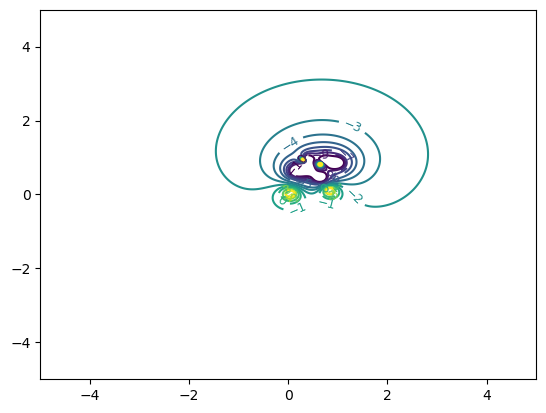

In [222]:
# add a new function g((x1,x2)) = r - 1.5 + cos**2(theta(r))(x1-1)**2 + sin**2(theta(r))x2**2 + sin(2theta(r))(x1-1)x2 + cos(theta(r))x1 - sin(theta(r))x2
# where theta(r) = pi/72 * r + 13pi/18
# and r = 1,2,3,4,5,6,7,8,9,10
# and the gradient of g is delta_g(x) = (2*cos**2(theta(r))(x1-1) + sin(2theta(r))x2 + cos(theta(r)), sin**2(theta(r))x2 + sin(2theta(r))(x1-1) - sin(theta(r)))
# we want to find the point x such that g(x) = 0
r = 5
def g(x):
	theta = np.pi/72 * r + 13*np.pi/18
	return r - 1.5 + np.cos(theta)**2 * (x[0]-1)**2 + np.sin(theta)**2 * x[1]**2 + np.sin(2*theta) * (x[0]-1) * x[1] + np.cos(theta) * x[0] - np.sin(theta) * x[1]

def delta_g(x):
	theta = np.pi/72 * r + 13*np.pi/18
	return np.array([2*np.cos(theta)**2 * (x[0]-1) + np.sin(2*theta) * x[1] + np.cos(theta), 2*np.sin(theta)**2 * x[1] + np.sin(2*theta) * (x[0]-1) - np.sin(theta)])

print(xi)
print(c)

# x = np.linspace(-1,1,1000)
# y = np.linspace(-1,1,1000)
# X,Y = np.meshgrid(x,y)
# Z = np.zeros((1000,1000))
# for i in range(1000):
# 	for j in range(1000):
# 		Z[i,j] = f((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
plt.show()

Test the function above


13.314639755290854
[ 1.00834696 -0.84363267]
Starting the attack
armijo_cond =  0.007468126461060241


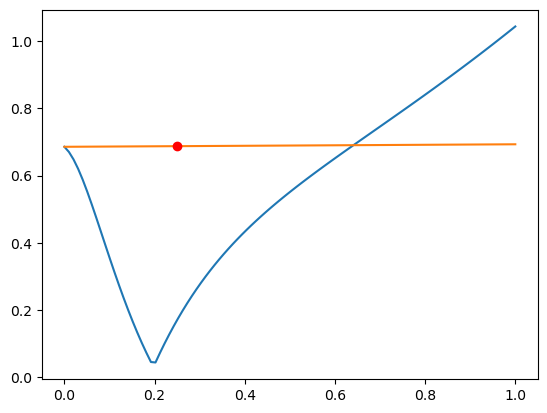

[-0.19250114 -0.03457515] x final

0.0457640529032024 f(x) final
[ 0.88120696 -0.90583422] deltaf(x) final
[ 1.00834696 -0.84363267] deltaf(x) initial
[-0.76696908  0.64168406] descent dir initial
[-0.19174227  0.16042101] x1-x0
[-0.19566682 -0.03827942] best x found
-0.00048206594688160465 best f(x) found
0.19937607688392361 norm of best x found
True


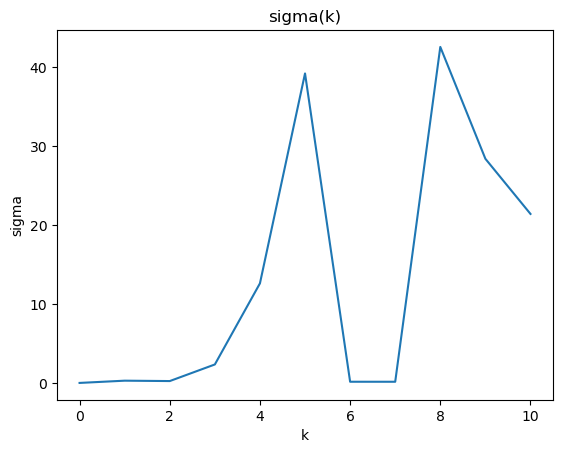

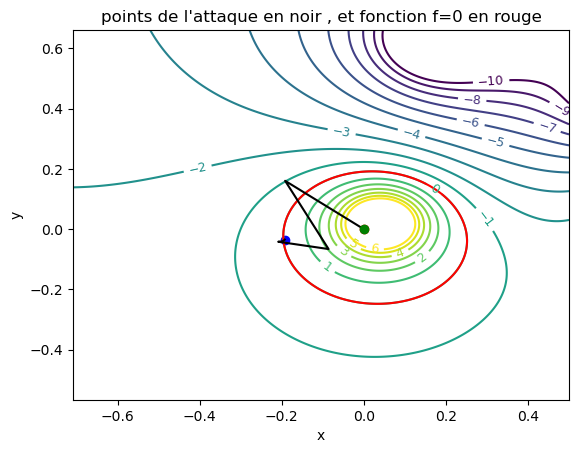

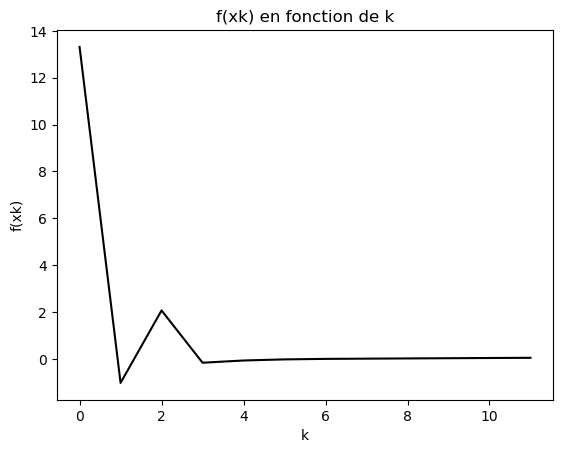

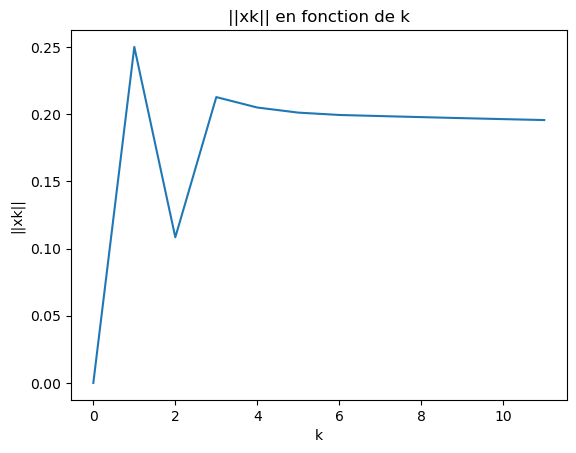

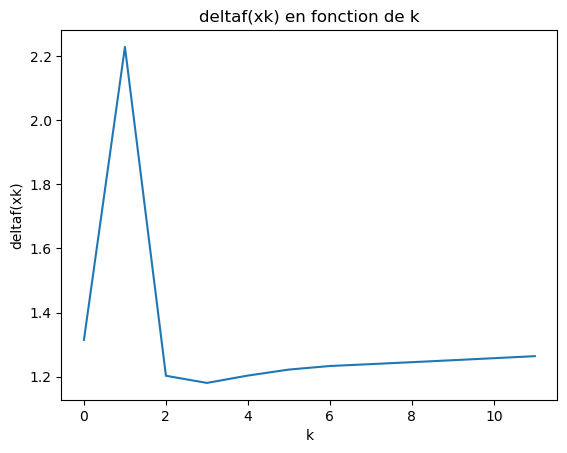

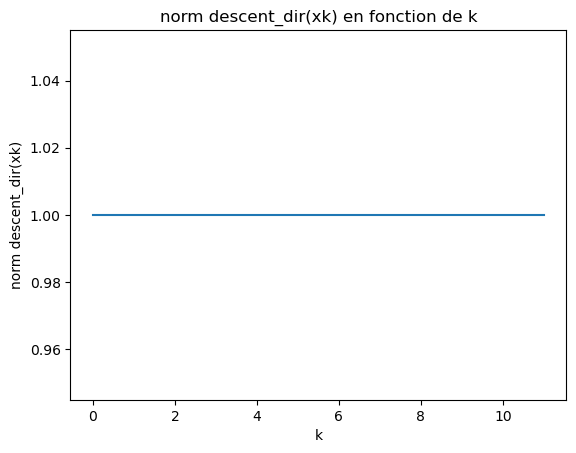

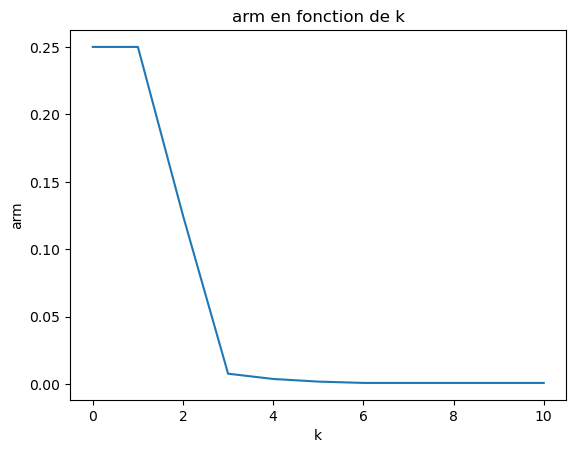

In [236]:
#test the attack
print(f((0,0)))
print(deltaf((0,0)))
attack = HLRF_attack(f,deltaf,maxiter=100,epsilon=0,omega=0.01,tau=0.5,c=1.2,show_mer_at_iter=2)
attack()
print(attack.x,"x final\n")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.dfs[0],"deltaf(x) initial")
print(attack.ds[0],"descent dir initial")
print(attack.xs[1] - attack.xs[0],"x1-x0")
print(attack.best_x,"best x found")
print(attack.f(attack.best_x),"best f(x) found")
print(np.linalg.norm(attack.best_x),"norm of best x found")

x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 0.5
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 0.5

if not(attack.found_adv):
	print(xi,'xi')
	print(c,'c')
print(attack.found_adv)

fig,ax = plt.subplots()
ax.plot(attack.sigmas)
ax.set_xlabel('k')
ax.set_ylabel('sigma')
ax.set_title('sigma(k)')
plt.show()

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black

x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))
for i in range(1000):
	for j in range(1000):
		Z[i,j] = f((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='red')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
ax.scatter(0,0,color='red')
#ax.plot(attack.best_x[0],attack.best_x[1],'black',marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en rouge')
plt.show()

#plot the function f at the points x0,x1,...,xk with seaborn

deltaf_norm = [np.linalg.norm(x) for x in attack.dfs]
descent_dir_norm = [np.linalg.norm(x) for x in attack.ds]

plt.subplots()
plt.plot(attack.fs,'-k')
plt.xlabel('k')
plt.ylabel('f(xk)')
plt.title('f(xk) en fonction de k')
plt.show()

plt.subplots()
plt.plot(np.linalg.norm(attack.xs,axis=1))
plt.xlabel('k')
plt.ylabel('||xk||')
plt.title('||xk|| en fonction de k')
plt.show()


plt.subplot()
plt.plot(deltaf_norm)
plt.xlabel('k')
plt.ylabel('deltaf(xk)')
plt.title('deltaf(xk) en fonction de k')
plt.show()

plt.subplot()
plt.plot(descent_dir_norm)
plt.xlabel('k')
plt.ylabel('norm descent_dir(xk)')
plt.title('norm descent_dir(xk) en fonction de k')
plt.show()

plt.subplot()
plt.plot(attack.arm)
plt.xlabel('k')
plt.ylabel('arm')
plt.title('arm en fonction de k')
plt.show()

Pareil avec fonction de merite de nhl-rf


13.314639755290854
[ 1.00834696 -0.84363267]
Starting the attack
[-12.54898446 -11.49700897] x final
-1.1081190538545405 f(x) final
[-0.03883107 -0.03768684] deltaf(x) final
[-0.69881755  0.75800777] best x found
-2.686156765457767 best f(x) found
1.0309809635462674 norm of best x found


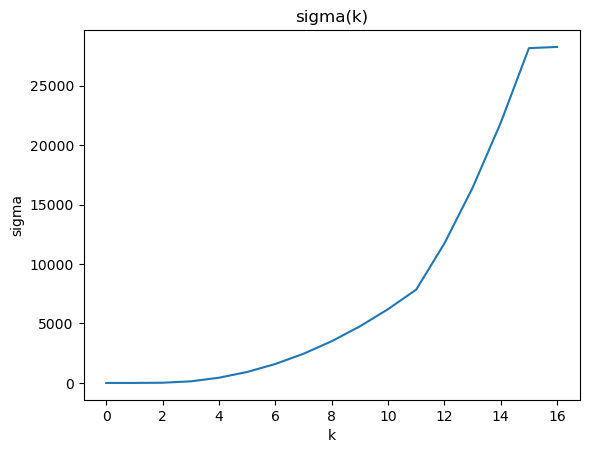

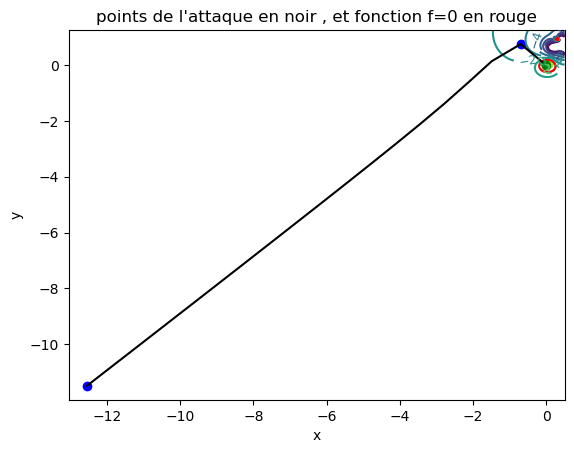

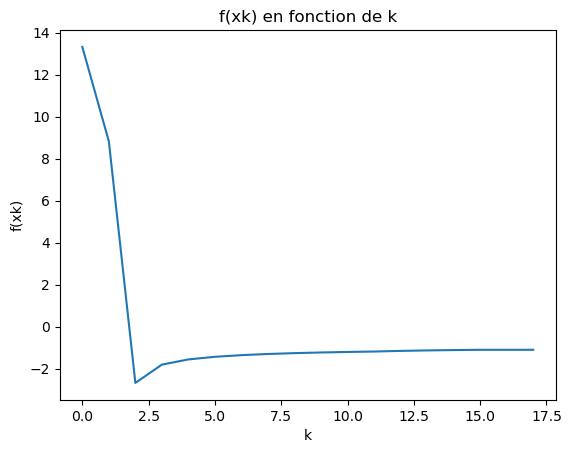

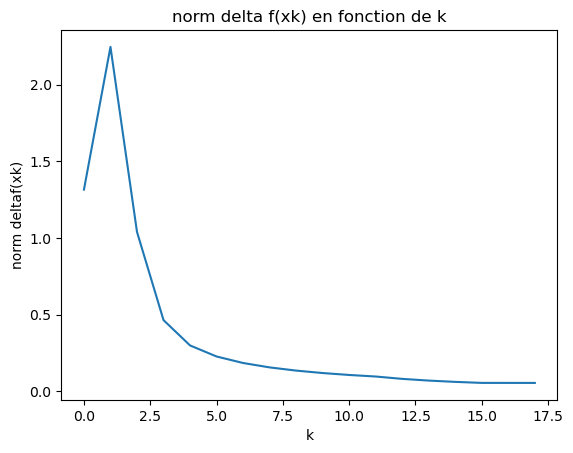

In [224]:
#test the attack
print(f((0,0)))
print(deltaf((0,0)))
attack = nHLRF_attack(f,deltaf,maxiter=100,omega=0.1,omega2=0.9)
attack()
print(attack.x,"x final")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.best_x,"best x found")
print(attack.f(attack.best_x),"best f(x) found")
print(np.linalg.norm(attack.best_x),"norm of best x found")

x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 0.5
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 0.5

fig,ax = plt.subplots()
ax.plot(attack.sigmas)
ax.set_xlabel('k')
ax.set_ylabel('sigma')
ax.set_title('sigma(k)')
plt.show()

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black

x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))
for i in range(1000):
	for j in range(1000):
		Z[i,j] = f((X[i,j],Y[i,j]))


fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='red')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.best_x[0],attack.best_x[1],color='blue')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
ax.scatter(0,0,color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en rouge')
plt.show()

#plot the function f at the points x0,x1,...,xk with seaborn

plt.subplots()
plt.plot(attack.fs)
plt.xlabel('k')
plt.ylabel('f(xk)')
plt.title('f(xk) en fonction de k')
plt.show()

norm_delta_f = [np.linalg.norm(x) for x in attack.dfs]
plt.subplots()
plt.plot(norm_delta_f)
plt.xlabel('k')
plt.ylabel('norm deltaf(xk)')
plt.title('norm delta f(xk) en fonction de k')
plt.show()

Starting the attack
armijo_cond =  -0.009279895180955912


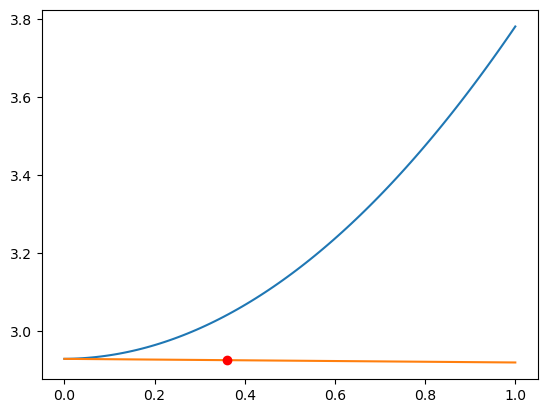

(0, 0) x initial
4.129409522551261 f(x) initial
[2.78132686 2.28938296] x final
0.0001185640767899232 f(x) final
[-0.7623593  -0.63254399] deltaf(x) final
[2.75758508 2.32166324] best x found
-0.00071915304607581 best f(x) found


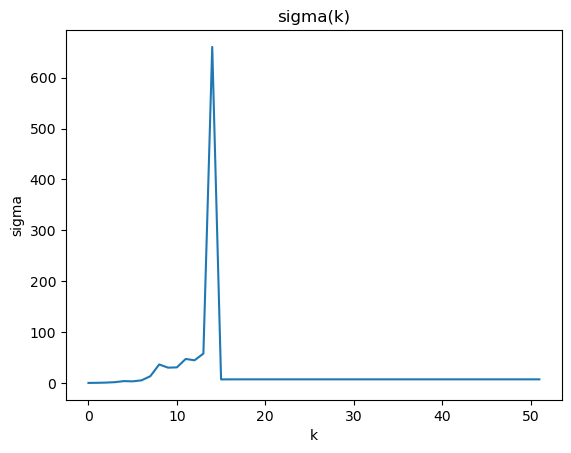

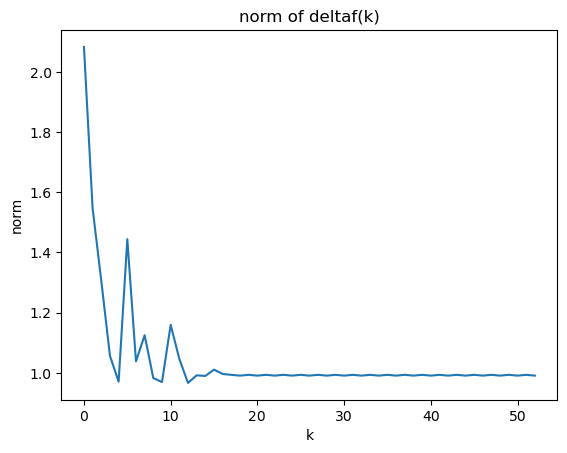

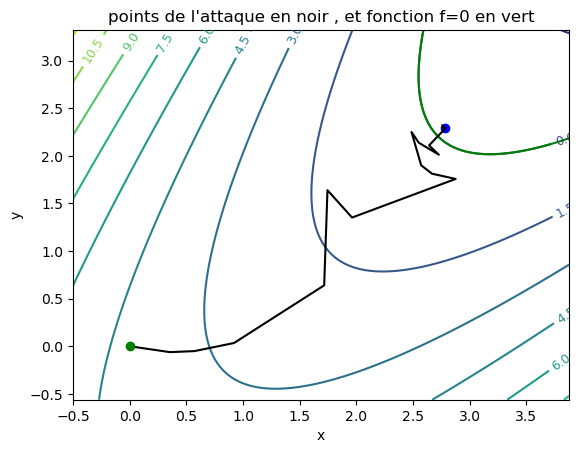

In [225]:
attack = HLRF_attack(g,delta_g,maxiter=500,epsilon=0.1,x0=(0,0),show_mer_at_iter=3)
attack()
print(attack.xs[0],"x initial")
print(attack.fs[0],"f(x) initial")
print(attack.x,"x final")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.best_x,"best x found")
print(attack.f(attack.best_x),"best f(x) found")

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black

x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 1
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 1

fig,ax = plt.subplots()
ax.plot(attack.sigmas)
ax.set_xlabel('k')
ax.set_ylabel('sigma')
ax.set_title('sigma(k)')
plt.show()

fig,ax = plt.subplots()
norm = [np.linalg.norm(x) for x in attack.dfs]
ax.plot(norm)
ax.set_xlabel('k')
ax.set_ylabel('norm')
ax.set_title('norm of deltaf(k)')
plt.show()


x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))	
for i in range(1000):
	for j in range(1000):
		Z[i,j] = g((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,10)
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='green')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
#ax.scatter(0,0,color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en vert')
plt.show()

Starting the attack
No adversarial example found
(0, 0) x initial
4.129409522551261 f(x) initial
[2.58086937 2.28389544] x final
0.18065060476913955 f(x) final
[-1.00939846 -0.44298418] deltaf(x) final
0.0434495635995257 f(x) best


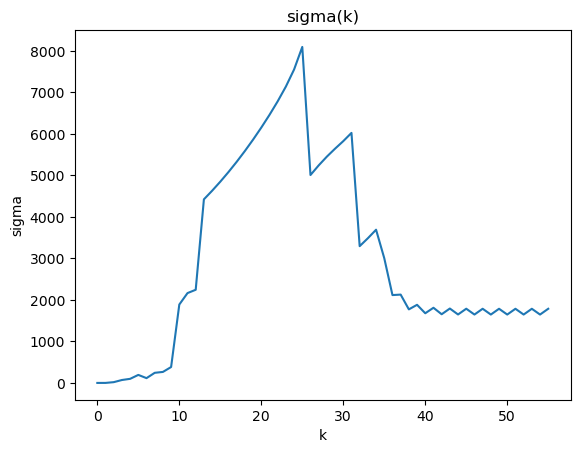

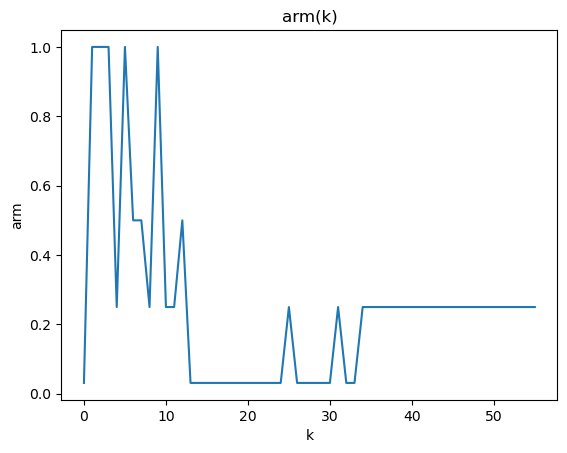

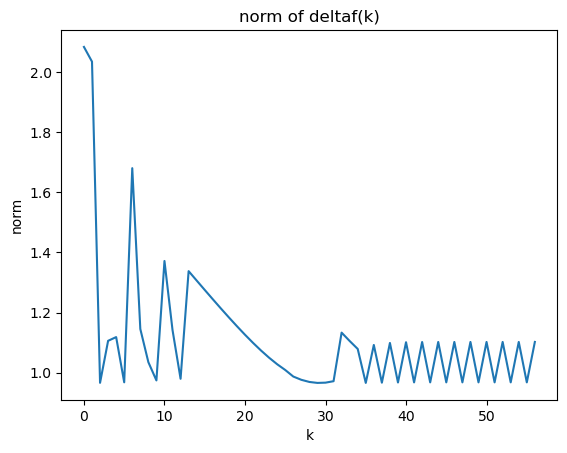

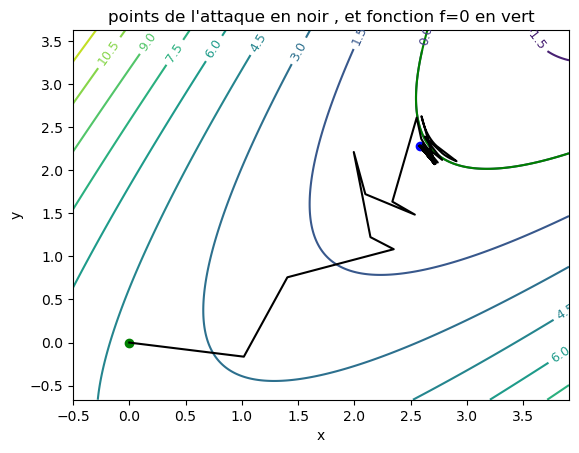

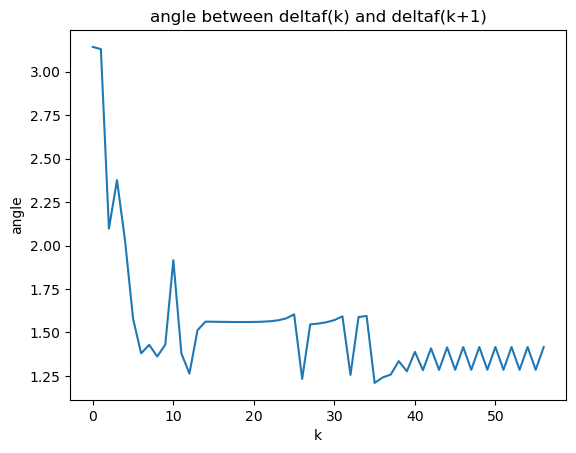

In [226]:
attack = nHLRF_attack(g,delta_g,maxiter=500,omega=0.1,omega2=0.9,x0=(0,0),epsilon=0.1)
attack()
print(attack.xs[0],"x initial")
print(attack.fs[0],"f(x) initial")
print(attack.x,"x final")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.f(attack.best_x),"f(x) best")


x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 1
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 1

fig,ax = plt.subplots()
ax.plot(attack.sigmas)
ax.set_xlabel('k')
ax.set_ylabel('sigma')
ax.set_title('sigma(k)')
plt.show()


fig,ax = plt.subplots()
ax.plot(attack.arm)
ax.set_xlabel('k')
ax.set_ylabel('arm')
ax.set_title('arm(k)')
plt.show()


fig,ax = plt.subplots()
norm = [np.linalg.norm(x) for x in attack.dfs]
ax.plot(norm)
ax.set_xlabel('k')
ax.set_ylabel('norm')
ax.set_title('norm of deltaf(k)')
plt.show()

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black




x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))	
for i in range(1000):
	for j in range(1000):
		Z[i,j] = g((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,10)
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='green')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
ax.scatter(attack.xs[0][0],attack.xs[0][1],color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en vert')
plt.show()

# print the angle between the gradient of f and the descent direction
# the angle should be close to 0°
angles = []
for i in range(len(attack.dfs)):
	angles.append(np.arccos(np.dot(attack.dfs[i],attack.ds[i])/(np.linalg.norm(attack.dfs[i])*np.linalg.norm(attack.ds[i]))))
fig,ax = plt.subplots()
ax.plot(angles)
ax.set_xlabel('k')
ax.set_ylabel('angle')
ax.set_title('angle between deltaf(k) and deltaf(k+1)')
plt.show()